In [9]:
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'

from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu

import numpy as np
import pandas as pd

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools

import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Initial data

In [2]:
vae = VAEUtils(directory='models/zinc_properties')

From /home/furiousteabag/anaconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
/home/furiousteabag/anaconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From /home/furiousteabag/anaconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From /home/furiousteabag/anaconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensor

Using standarized functions? True
Standarization: estimating mu and std values ...done!


In [3]:
sample_data = ['Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1', 
               'CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C',
               'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1'] 

# First sample

## Encode / Decode   

smiles -> x -> z -> x_decoded -> smiles_decoded

In [4]:
smiles = mu.canon_smiles(sample_data[0])

x = vae.smiles_to_hot(smiles, canonize_smiles=True)
z = vae.encode(x)
x_decoded = vae.decode(z)
smiles_decoded = vae.hot_to_smiles(x_decoded,strip=True)[0]

print('{:20s} : {}'.format('Input', smiles))
print('{:20s} : {}'.format('Reconstruction', smiles_decoded)) 
print('{:20s} : {} with norm {:.3f}'.format('Z representation', z.shape, np.linalg.norm(z)))

Input                : Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
Reconstruction       : Cc1ccc(-](=OC(NC(=O)Nc3ccccc32)cc1
Z representation     : (1, 196) with norm 10.265


## Decode several attempts

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 4 unique mols, out of 16
SMILES
 0    Cc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1
1    Cc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1
2    Fc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1
3    C1cccc(C[n+]2=NC(=O)Nc3ccccc32)cc1
Name: smiles, dtype: object


RDKit ERROR: [21:54:36] Can't kekulize mol.  Unkekulized atoms: 2 3 4 17 18
RDKit ERROR: 
RDKit ERROR: [21:54:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted
RDKit ERROR: [21:54:36] SMILES Parse Error: syntax error while parsing: CO1ccc(S[n-]2+]c(=O)Nc3ccccc32)cc1
RDKit ERROR: [21:54:36] SMILES Parse Error: Failed parsing SMILES 'CO1ccc(S[n-]2+]c(=O)Nc3ccccc32)cc1' for input: 'CO1ccc(S[n-]2+]c(=O)Nc3ccccc32)cc1'
RDKit ERROR: [21:54:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted
RDKit ERROR: [21:54:36] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [21:54:36] Explicit valence for atom # 0 Cl, 2, is greater than permitted
RDKit ERROR: [21:54:36] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [21:54:36] SMILES Parse Error: syntax error while parsing: Cc1ccc(/CN+]2=NC(=O)Nc3ccccc32)cc1
RDKit ERROR: [21:54:36] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(/CN+]2=NC(=O)Nc3ccccc32)cc1' for input

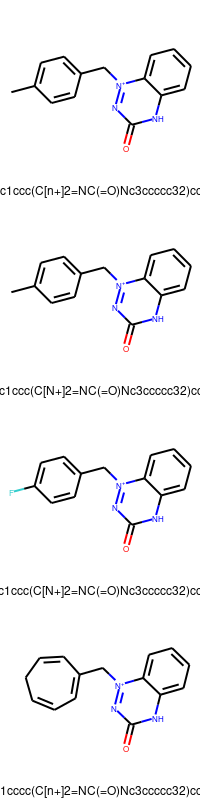

,smiles,distance,count,frequency,mol
0,Cc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1,10.703051,6,0.3750,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,Cc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1,10.703051,8,0.5000,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,Fc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1,14.055407,1,0.0625,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,C1cccc(C[n+]2=NC(=O)Nc3ccccc32)cc1,16.242690,1,0.0625,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [5]:
noise=5.0

print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))

df = vae.z_to_smiles(z, decode_attempts=100, noise_norm=noise)

print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])), sum(df['count'])))
print('SMILES\n', df.smiles)
display(PandasTools.FrameToGridImage(df, column='mol', legendsCol='smiles', molsPerRow=1))
df.head()

## Predicting properties

In [6]:
y = vae.predict_prop_Z(z)[0]
print('QED: {}\nSAS: {}\nlogP: {}'.format(*y))

QED: 0.7231325507164001
SAS: 2.410372495651245
logP: 3.1467232704162598


# Second sample

## Encode / Decode   

smiles -> x -> z -> x_decoded -> smiles_decoded

In [7]:
smiles = mu.canon_smiles(sample_data[1])

x = vae.smiles_to_hot(smiles, canonize_smiles=True)
z = vae.encode(x)
x_decoded = vae.decode(z)
smiles_decoded = vae.hot_to_smiles(x_decoded,strip=True)[0]

print('{:20s} : {}'.format('Input', smiles))
print('{:20s} : {}'.format('Reconstruction', smiles_decoded)) 
print('{:20s} : {} with norm {:.3f}'.format('Z representation', z.shape, np.linalg.norm(z)))

Input                : CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
Reconstruction       : CN(C1cccc2c(c1)C(=O)C@@)C(=O)OC(C)(C)C
Z representation     : (1, 196) with norm 13.434


## Decode several attempts

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 1 unique mols, out of 4
SMILES
 0    CN(C1cccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
Name: smiles, dtype: object


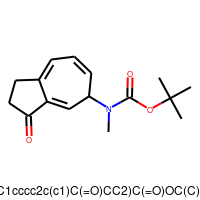

,smiles,distance,count,frequency,mol
0,CN(C1cccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C,18.257776,4,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [10]:
noise = 5.0

print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))

df = vae.z_to_smiles(z, decode_attempts=100, noise_norm=noise)

print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])), sum(df['count'])))
print('SMILES\n', df.smiles)
display(PandasTools.FrameToGridImage(df, column='mol', legendsCol='smiles', molsPerRow=1))
df.head()

## Predicting properties

In [11]:
y = vae.predict_prop_Z(z)[0]
print('QED: {}\nSAS: {}\nlogP: {}'.format(*y))

QED: 0.8115883469581604
SAS: 2.219855308532715
logP: 2.4382762908935547


# Third sample

## Encode / Decode   

smiles -> x -> z -> x_decoded -> smiles_decoded

In [12]:
smiles = mu.canon_smiles(sample_data[2])

x = vae.smiles_to_hot(smiles, canonize_smiles=True)
z = vae.encode(x)
x_decoded = vae.decode(z)
smiles_decoded = vae.hot_to_smiles(x_decoded,strip=True)[0]

print('{:20s} : {}'.format('Input', smiles))
print('{:20s} : {}'.format('Reconstruction', smiles_decoded)) 
print('{:20s} : {} with norm {:.3f}'.format('Z representation', z.shape, np.linalg.norm(z)))

Input                : COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1
Reconstruction       : COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)N=O)n2)C@1
Z representation     : (1, 196) with norm 13.109


## Decode several attempts

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 5 unique mols, out of 58
SMILES
 0    COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1
1    COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NN)cn2)CC1
2     COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)cn2)C1
3    COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)cn2)CC1
4    COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NC)cn2)CC1
Name: smiles, dtype: object


RDKit ERROR: [21:57:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [21:57:48] SMILES Parse Error: syntax error while parsing: COC(=O)C1CC(NOc2ccc(NC(=O)C(=O)NC)cn2)C@1
RDKit ERROR: [21:57:48] SMILES Parse Error: Failed parsing SMILES 'COC(=O)C1CC(NOc2ccc(NC(=O)C(=O)NC)cn2)C@1' for input: 'COC(=O)C1CC(NOc2ccc(NC(=O)C(=O)NC)cn2)C@1'
RDKit ERROR: [21:57:48] SMILES Parse Error: syntax error while parsing: COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)C@H]1
RDKit ERROR: [21:57:48] SMILES Parse Error: Failed parsing SMILES 'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)C@H]1' for input: 'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)C@H]1'
RDKit ERROR: [21:57:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [21:57:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19 20 21
RDKit ERROR: 
RDKit ERROR: [21:57:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [21:57:48] Can't kekulize mol.  Unkekulized atoms

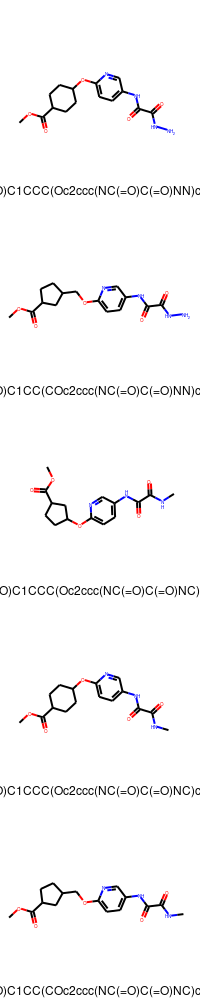

,smiles,distance,count,frequency,mol
0,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1,0.000007,42,0.724138,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NN)cn2)CC1,8.870868,4,0.068966,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)cn2)C1,14.451388,1,0.017241,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)cn2)CC1,14.737485,10,0.172414,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NC)cn2)CC1,15.473076,1,0.017241,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [13]:
noise=5.0

print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))

df = vae.z_to_smiles(z, decode_attempts=100, noise_norm=noise)

print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])), sum(df['count'])))
print('SMILES\n', df.smiles)
display(PandasTools.FrameToGridImage(df, column='mol', legendsCol='smiles', molsPerRow=1))
df.head()

## Predicting properties

In [14]:
y = vae.predict_prop_Z(z)[0]
print('QED: {}\nSAS: {}\nlogP: {}'.format(*y))

QED: 0.7531524896621704
SAS: 2.4784982204437256
logP: 0.0503462553024292
